# Estimation des hyperparamètres - Gibbs

Dans ce notebook, on s'intéresse à un modèle simple
$$y = Ax + b$$
où $b$ est un bruit gaussien centré de matrice de covariance $\sigma_b^2 I$, et $x$ un signal à reconstruire, suivant une loi normale centrée de matrice de covariance $I / \tau$. Le paramètre $\tau$ sera également estimé.


In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

**Question 1** : On choisit d'imposer l'a priori que $\tau$ suit une loi $\Gamma$. Justifier ce choix.

**Question 2** : Écrire la vraisemblance $p(y | x)$, la loi a priori $p(x, \tau)$ et la loi a posteriori $p(x, \tau | y)$.

**Question 3** : Coder la fonction permettant de simuler des données.

In [3]:
def generate_data(A, sigma_n, alpha, beta):
    
    tau = rand.gamma(alpha, 1/beta)
    
    x = rand.multivariate_normal(np.zeros([A.shape[1]]), np.eye(A.shape[1]) / tau);
    b = rand.multivariate_normal(np.zeros([A.shape[0]]), np.eye(A.shape[0]) * sigma_n);
    y = A @ x + b
    
    return y, x, tau

**Question 4** : Déterminer les lois $p(x|\tau, y)$ et $p(\tau | x, y)$ et implémenter l'échantilloneur de Gibbs.

((A
?R
−1
b A + R
−1
x
)
−1A
?R
−1
b
y((A
?R
−1
b A + R
−1
x
)
−1A
?R
−1
b
y

In [4]:
def sample_tau(x, y, alpha, beta):
    
    alpha2 = alpha  + x.shape[0] / 2
    beta2 = beta + sum(x**2) / 2
    tau = rand.gamma(alpha2, 1/beta2)
    return tau


def sample_x(y, tau, A, sigma_n):
    
    Reap = np.linalg.inv(A.T @ A / sigma_n + tau * np.eye(A.shape[1]))
    Xeap = Reap @ A.T @ y / sigma_n
    
    x = rand.multivariate_normal(Xeap, Reap);
    
    return x

def gibbs(y, A, alpha, beta, sigma2, x0, tau0, q, L):

    
    Xsamples = np.zeros([x0.shape[0], L])
    Tausamples = np.zeros([L])
    
    Xsamples[:, 0] = x0
    Tausamples[0] = tau0
    
    for k in range(1,L):
        if rand.rand(1) > q:
            Xsamples[:, k] = sample_x(y, Tausamples[k-1], A, sigma_n)
            Tausamples[k] = Tausamples[k-1]
        else:
            Tausamples[k] = sample_tau(Xsamples[:, k-1], y, alpha, beta)
            
            Xsamples[:, k] = Xsamples[:, k-1]
    
    return Xsamples, Tausamples

**Question 5** : Donner l'estimation de $x$ en utilisant la valeur de $\tau$ moyenne a priori ($\alpha/ \beta)$, et en utilisant la vrai valeur de $\tau$. Comparer avec le résultat de l'estimation conjointe de $x$ et $\tau$ en simulation un grand nombre de données. Optionnel : tester l'estimation conjointe avec des paramètres $\alpha$ et $\beta$ différents des paramètres utilisés pour générer les données.

In [5]:
N = 30;

A = rand.randn(N, N)

sigma_n = 0.1
alpha = 0.5
beta = 0.5
y, x, tau = generate_data(A, sigma_n, alpha, beta)

In [6]:
Ns = 10_000;

R0 = np.linalg.inv(A.T @ A / sigma_n + (alpha/beta) * np.eye(A.shape[1]))

y, x, tau = generate_data(A, sigma_n, alpha, beta)
    
XS, TS = gibbs(y, A, alpha, beta, sigma_n, np.zeros([N]), 1, 0.5, Ns)

In [9]:
Xgibbs = np.mean(XS, axis=1)

In [10]:
Roracle = np.linalg.inv(A.T @ A / sigma_n + tau * np.eye(A.shape[1]))
Xoracle = Roracle@ A.T @ y / sigma_n

Rtauap = np.linalg.inv(A.T @ A / sigma_n + (alpha/beta) * np.eye(A.shape[1]))
Xtauap = Rtauap @ A.T @ y / sigma_n

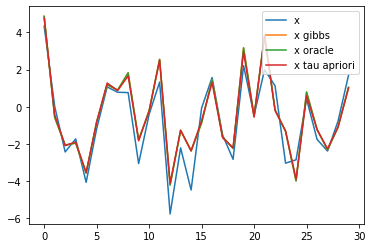

In [11]:
plt.plot(x, label ="x")
plt.plot(Xgibbs, label="x gibbs")
plt.plot(Xoracle, label = "x oracle")
plt.plot(Xtauap, label = "x tau apriori")
plt.legend()